# Credit Appraiser Models

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math

from sklearn.model_selection import train_test_split

# Models
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import os

PROJECT_ROOT_DIR = "."

IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "credit_appraiser_images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

%matplotlib inline

In [2]:
credit = pd.read_csv('explore.csv', index_col=0)
explore = credit.copy()

In [3]:
explore.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'bi_combined_late'],
      dtype='object')

In [4]:
def plot_roc_curve(fp_rate, tp_rate):
    '''Plot the ROC Curve given the false positive and true positive rates'''
    plt.figure(figsize=(8,8))
    plt.plot(fp_rate, tp_rate)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(explore,
                                                   explore['SeriousDlqin2yrs'],
                                                   test_size=.2,
                                                   stratify=explore['SeriousDlqin2yrs'],
                                                   random_state=24)
scaler = StandardScaler().fit(X_train)

X_train = X_train.drop(columns='SeriousDlqin2yrs')
X_test = X_test.drop(columns='SeriousDlqin2yrs')

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.

### Logistic Regression

#### Default Parameter Logistic Regression

In [6]:
logR = LogisticRegression()

logR.fit(X_train_scaled, y_train)

logR_pred_proba = logR.predict_proba(X_train_scaled)
logR_pred = logR_pred_proba[:, 1]

print('logR Training ROC Score:', sklearn.metrics.roc_auc_score(y_train, logR_pred))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logR Training ROC Score: 0.8101381050774722


In [7]:
logR_test_proba = logR.predict_proba(X_test_scaled)
logR_test_pred = logR_test_proba[:, 1]

logR_roc = sklearn.metrics.roc_auc_score(y_test, logR_test_pred)

print('logR Testing ROC Score:', logR_roc)

logR Testing ROC Score: 0.8098425128463


#### Fine-tuned Logistic Regression

In [8]:
log_params = [{'penalty' : ['l1', 'l2'], 
               'C' : [.001, 1, 1000], 
               'class_weight' : ['balanced'], 
               'max_iter' : [100, 500],
               'solver' : ['saga']
}]

log_search = GridSearchCV(estimator=logR, param_grid=log_params, scoring='roc_auc')
log_search.fit(X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': [0.001, 1, 1000], 'class_weight': ['balanced'], 'max_iter': [100, 500], 'solver': ['saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [9]:
tuned_logR = log_search.best_estimator_
tuned_logR.fit(X_train_scaled, y_train)
tuned_logR_test_proba = tuned_logR.predict_proba(X_test_scaled)
tuned_logR_test_pred = tuned_logR_test_proba[:, 1]

tuned_logR_roc = sklearn.metrics.roc_auc_score(y_test, tuned_logR_test_pred)

print('tuned_logR Testing ROC Score:', tuned_logR_roc)

tuned_logR Testing ROC Score: 0.8192657488267187


In [10]:
fpr_tuned_logR, tpr_tuned_logR, thresh_tuned_logR = roc_curve(y_test, tuned_logR_test_pred)

Text(0.5,1,'tuned_logR ROC Curve')

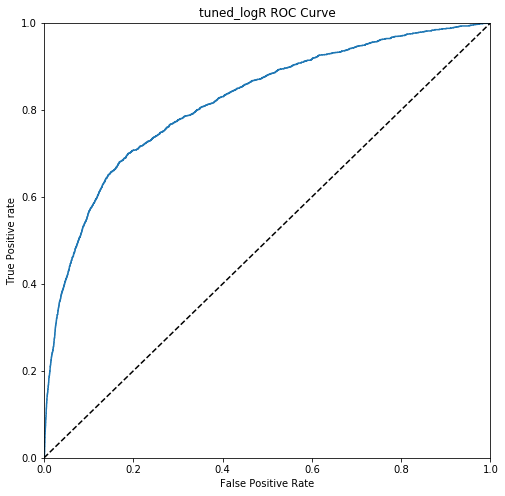

In [11]:
plot_roc_curve(fpr_tuned_logR, tpr_tuned_logR)
plt.title('tuned_logR ROC Curve')

The Logistic Regression Model gets a .819 ROC AUC score on the validation set when fine-tuned.

Interestingly, this is hardly better than the results with the default parameters.

In [12]:
print('The best parameters for logistic regression:', log_search.best_params_)

The best parameters for logistic regression: {'C': 1000, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


### K-Nearest Neighbors

#### Default Parameter KNN

In [13]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [14]:
knn_pred_proba = knn.predict_proba(X_train_scaled)
knn_pred = knn_pred_proba[:, 1]

print('knn Training ROC Score:', sklearn.metrics.roc_auc_score(y_train, knn_pred))

knn Training ROC Score: 0.9486169780803124


In [15]:
knn_test_proba = knn.predict_proba(X_test_scaled)
knn_test_pred = knn_test_proba[:, 1]

knn_roc = sklearn.metrics.roc_auc_score(y_test, knn_test_pred)

print('knn Testing ROC Score:', knn_roc)

knn Testing ROC Score: 0.7168888192093441


#### Fine-tuned KNN

In [16]:
k = [3, 5]
knn_params = [{'n_neighbors' : k
}]

knn_search = GridSearchCV(estimator=knn, param_grid=knn_params, scoring='roc_auc')
knn_search.fit(X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [3, 5]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [17]:
tuned_knn = knn_search.best_estimator_
tuned_knn.fit(X_train_scaled, y_train)
tuned_knn_test_proba = tuned_knn.predict_proba(X_test_scaled)
tuned_knn_test_pred = tuned_knn_test_proba[:, 1]

Text(0.5,1,'Tuned knn ROC Curve')

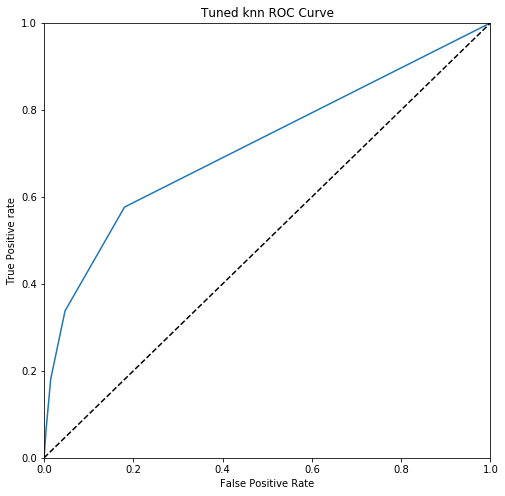

In [18]:
fpr_tuned_knn, tpr_tuned_knn, thresh_tuned_knn = roc_curve(y_test, tuned_knn_test_pred)
plot_roc_curve(fpr_tuned_knn, tpr_tuned_knn)
plt.title('Tuned knn ROC Curve')

In [19]:
tuned_knn_test_proba = tuned_knn.predict_proba(X_test_scaled)
tuned_knn_test_pred = tuned_knn_test_proba[:, 1]

print('tuned_logR Testing ROC Score:', sklearn.metrics.roc_auc_score(y_test, tuned_knn_test_pred))

tuned_logR Testing ROC Score: 0.7168888192093441


K-Nearest Neighbors has overfit problem, is less accurate, and slower. In fact, it is so slow, I'm never running it again and you'll just have to take my word for it.

### Random Forest Classifier

#### Default Parameter Random Forest

In [20]:
rfc = ensemble.RandomForestClassifier(random_state=24)
rfc.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

In [21]:
rfc_pred_proba = rfc.predict_proba(X_train)
rfc_pred = rfc_pred_proba[:, 1]

print('rfc Training ROC Score:', sklearn.metrics.roc_auc_score(y_train, rfc_pred))

rfc Training ROC Score: 0.9997036173760558


In [22]:
rfc_test_proba = rfc.predict_proba(X_test)
rfc_test_pred = rfc_test_proba[:, 1]

rfc_roc = sklearn.metrics.roc_auc_score(y_test, rfc_test_pred)

print('rfc Testing ROC Score:', rfc_roc)

rfc Testing ROC Score: 0.7757775145989285


In [23]:
rfc_params =[{'n_estimators':[10,],
             'max_features':['auto', 'sqrt', 'log2'],
             'min_samples_split':[2,8,20],
             'bootstrap':[True, False],
             'max_depth':[None,5,6,7,8]
}]

In [24]:
tuned_rfc = ensemble.RandomForestClassifier(random_state=24, n_estimators=10, class_weight='balanced')
tuned_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False, random_state=24,
            verbose=0, warm_start=False)

In [25]:
X_train.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'bi_combined_late'],
      dtype='object')

In [26]:
tuned_rfc_pred_proba = tuned_rfc.predict_proba(X_train)
tuned_rfc_pred = tuned_rfc_pred_proba[:, 1]

print('tuned_rfc Training ROC Score:', sklearn.metrics.roc_auc_score(y_train, tuned_rfc_pred))

tuned_rfc_test_proba = tuned_rfc.predict_proba(X_test)
tuned_rfc_test_pred = tuned_rfc_test_proba[:, 1]

tuned_rfc_roc = sklearn.metrics.roc_auc_score(y_test, tuned_rfc_test_pred)

print('tuned_rfc Testing ROC Score:', tuned_rfc_roc)

tuned_rfc Training ROC Score: 0.9995908314104422
tuned_rfc Testing ROC Score: 0.7727320117281363


In [27]:
X_train.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'bi_combined_late'],
      dtype='object')

In [28]:
testing123 = pd.DataFrame(columns=X_train.columns, data=[[1, 2, 3, 4, 5, 6, 7,8,9,10,11]])

In [29]:
testing123

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,bi_combined_late
0,1,2,3,4,5,6,7,8,9,10,11


In [30]:
tuned_rfc.predict_proba(testing123)

array([[0.9, 0.1]])

Text(0.5,1,'Tuned rfc ROC Curve')

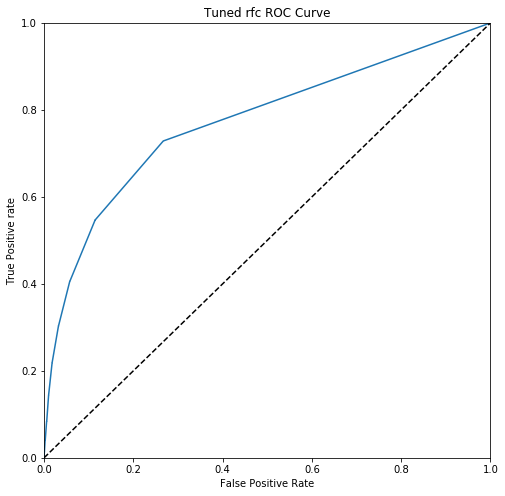

In [31]:
tuned_fpr_rfc, tuned_tpr_rfc, tuned_thresh_rfc = roc_curve(y_test, tuned_rfc_test_pred)
plot_roc_curve(tuned_fpr_rfc, tuned_tpr_rfc)
plt.title('Tuned rfc ROC Curve')

Random forest also overfits but still manages to do significantly better than K-Nearest Neighbors. Running Gridsearch on random forest takes so long to do on my computer that I have just replaced it with the best parameters that it gave me.

### Gradient Boosting Classifier

#### Default Parameter Gradient Boosting Classifier

In [32]:
gbc = ensemble.GradientBoostingClassifier(random_state=24, n_estimators=200)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=24,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [33]:
gbc_pred_proba = gbc.predict_proba(X_train)
gbc_pred = gbc_pred_proba[:, 1]

print("gbc Training ROC Score:", sklearn.metrics.roc_auc_score(y_train, gbc_pred))

gbc Training ROC Score: 0.8725324741776976


In [34]:
gbc_test_proba = gbc.predict_proba(X_test)
gbc_test_pred = gbc_test_proba[:, 1]

gbc_roc = sklearn.metrics.roc_auc_score(y_test, gbc_test_pred)

print("gbc Testing ROC Score:", gbc_roc)

gbc Testing ROC Score: 0.868585127643474


#### Fine-tuned Gradient Boosting Classifier

In [35]:
gbc_params = [{'learning_rate' : [.05, .1], 
               'n_estimators' : [100, 200]
}]

search_gbc = GridSearchCV(estimator=gbc, param_grid=gbc_params, scoring='roc_auc')
search_gbc.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [36]:
tuned_gbc = search_gbc.best_estimator_
tuned_gbc

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=24,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [37]:
tuned_gbc.fit(X_train, y_train)
tuned_gbc_test_proba = tuned_gbc.predict_proba(X_test)
tuned_gbc_test_pred = tuned_gbc_test_proba[:, 1]

tuned_gbc_roc = sklearn.metrics.roc_auc_score(y_test, tuned_gbc_test_pred)

print('tuned_gbc Testing ROC Score:', tuned_gbc_roc)

tuned_gbc Testing ROC Score: 0.868585127643474


Saving figure tuned gbc roc


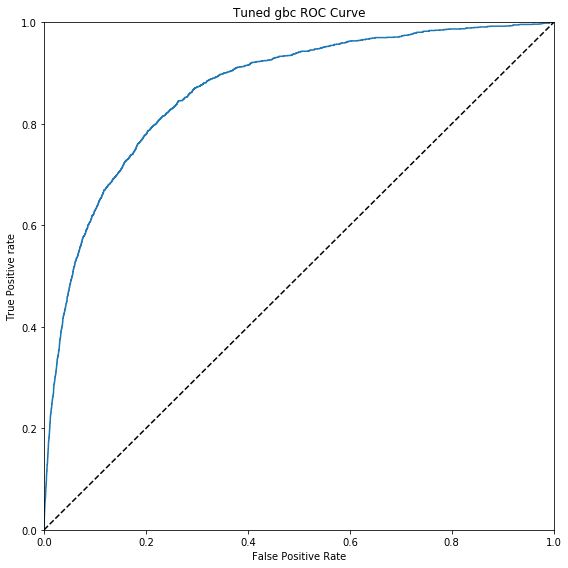

In [38]:
fpr_gbc, tpr_gbc, thresh_gbc = roc_curve(y_test, tuned_gbc_test_pred)
plot_roc_curve(fpr_gbc, tpr_gbc)
plt.title('Tuned gbc ROC Curve')
save_fig("tuned gbc roc")

Unbelievably, GridSearchCV actually makes gradient boosting somehow less accurate. Which makes no sense because the default parameters were included in the param grid, so it should, at worst, tie the default scores.

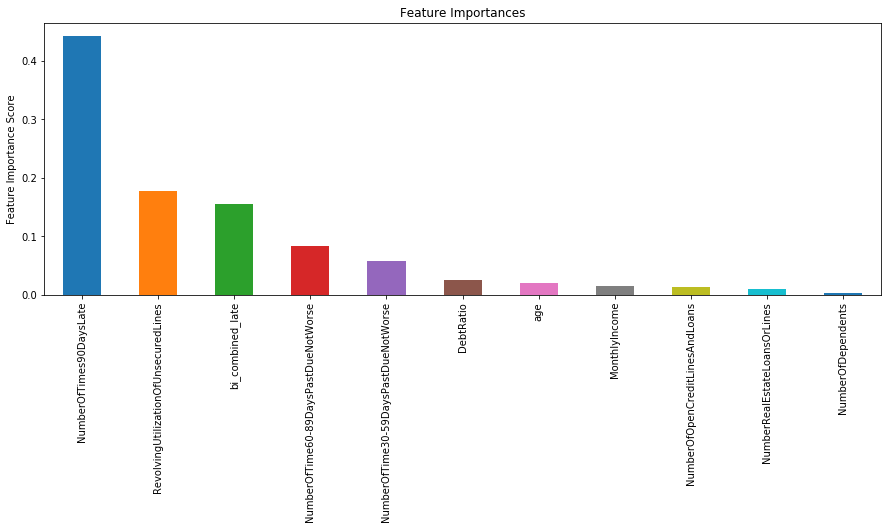

In [39]:
# Plotting Feature Importances from Gradient Boosting Classifier
feat_imp = pd.Series(gbc.feature_importances_, X_train.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(15,5))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xticks(rotation=90)
plt.show()

In [40]:
imp_train = X_train.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse'])


imp_gbc = ensemble.GradientBoostingClassifier(random_state=24, n_estimators=200, learning_rate=.05)
imp_gbc.fit(imp_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=24,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [41]:
imp_test = X_test.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse'])

imp_gbc_test_proba = imp_gbc.predict_proba(imp_test)
imp_gbc_test_pred = imp_gbc_test_proba[:, 1]

imp_gbc_roc = sklearn.metrics.roc_auc_score(y_test, imp_gbc_test_pred)

print('imp_gbc Testing ROC Score:', imp_gbc_roc)

imp_gbc Testing ROC Score: 0.8668807976486717


Dropping more columns does not lead to an increase in accuracy.

In [42]:
tuned_knn_roc = "Takes too long"

In [43]:
results = pd.DataFrame([[logR_roc, tuned_logR_roc],  [knn_roc, tuned_knn_roc],  [rfc_roc, tuned_rfc_roc], [gbc_roc, tuned_gbc_roc]])

In [44]:
results.columns = ['Default Params', 'Tuned Params']
results.index = ['LogR', 'knn', 'rfc', 'gbc']

In [45]:
results

,Default Params,Tuned Params
LogR,0.809843,0.819266
knn,0.716889,Takes too long
rfc,0.775778,0.772732
gbc,0.868585,0.868585


In [46]:
results.to_csv('capstone_model_results.csv')

In [47]:
# This is for use in a website
import dill as pickle

filename = 'tuned_rfc.pk'

with open('/Users/lukeelliott/Desktop/web1/gmsc/'+filename, 'wb') as file:
    pickle.dump(tuned_rfc, file)